### This presents my solution to Moz data challenge

#### import libraries

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


#### import data

In [31]:
test_path = 's3://mozbi-sr-data-science/data/moz_customer_data_test.csv'
train_path = 's3://mozbi-sr-data-science/data/moz_customer_data_train.csv'

In [101]:
train_ori = pd.read_csv(test_path,sep='|')
test_ori = pd.read_csv(train_path,sep='|')

In [102]:
train = train_ori.copy()
test = test_ori.copy()

In [33]:
train.head()

,id,industry,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid
0,8721560330,health care,America,Safari,405,94.086123
1,5265684450,unk,England,IE,4460,44.434942
2,7023768415,Marketing Agency,Esp,Firefox,289,53.311472
3,7733403428,NaN,America,Firefox,4242,98.500425
4,9147925075,NaN,USA,Safari,431,76.246123


In [15]:
train.shape

(12000, 6)

In [16]:
test.shape

(48000, 6)

#### data has high quality, only one columns has NA values

In [22]:
train.isna().sum()

id                                     0
industry                            1713
geography                              0
most_common_browser                    0
session_time_prior_month_seconds       0
prior_month_paid                       0
dtype: int64

#### further check shows that the industy already has a unknown category, I will use it to impute the NA. <br> The 'unk' category seem to be same as 'unknown', i will look into this further

In [18]:
train.industry.value_counts()

Marketing Agency    1556
health care         1537
software            1533
mktg agency         1524
healthcare          1481
marketing agency    1420
unknown              623
unk                  613
Name: industry, dtype: int64

#### looking into geography data

In [81]:
train.geography.value_counts()

USA               2174
Canada            1288
CA                1251
United States     1096
America           1073
US                1003
UK                 529
India              483
Pakistan           472
Spain              470
Esp                460
France             448
Greece             437
United Kingdom     286
England            272
GB                 258
Name: geography, dtype: int64

### I will make some assumptions about the countries
#### there are different names for one country, i need to combine them. i'll leave america out as it might refer to the continent, this is just assumption <br> other UK and USA should be combined<br> I will assume CA means Canada here, might be able to confirm with distributions or more data

In [88]:
country_dic = {'United States':'US','CA':'Canada','USA':'US','Esp':'Spain','United Kingdom':'UK','GB':'UK','England':'UK'}


In [181]:
train.geography = train.geography.apply(lambda x:country_dic[x] if x in country_dic else x)
train.geography.value_counts()

US          4273
Canada      2539
UK          1345
America     1073
Spain        930
India        483
Pakistan     472
France       448
Greece       437
Name: geography, dtype: int64

#### now check on industry

In [185]:
train.industry.value_counts()

unknown             2949
Marketing Agency    1556
health care         1537
software            1533
mktg agency         1524
healthcare          1481
marketing agency    1420
Name: industry, dtype: int64

#### similar duplicate issue as countries. i will combine them below

In [186]:
industry_dic = {'mktg agency':'marketing agency','health care':'healthcare','Marketing Agency':'marketing agency'}

In [188]:
train.industry = train.industry.apply(lambda x:industry_dic[x] if x in industry_dic else x)
train.industry.value_counts()

marketing agency    4500
healthcare          3018
unknown             2949
software            1533
Name: industry, dtype: int64

#### use hist plot to check client's geography data distribution to compare between unknow, unk and other categoies
#### my assumption here is unknown industy should have a simiar distribution accross different countries

In [189]:
unk = train[train.industry=='unk'].groupby(['geography']).mean().session_time_prior_month_seconds
unknown = train[train.industry=='unknown'].groupby(['geography']).mean().session_time_prior_month_seconds
na = train[train.industry.isna()].groupby(['geography']).mean().session_time_prior_month_seconds
unknown_cat = pd.concat([unk,unknown,na],axis =1)
unknown_cat.columns = ['unk','unkown','na']

C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [145]:
unk = train[train.industry=='unk'].groupby(['geography']).count().session_time_prior_month_seconds
unknown = train[train.industry=='unknown'].groupby(['geography']).count().session_time_prior_month_seconds
na = train[train.industry.isna()].groupby(['geography']).count().session_time_prior_month_seconds
unknown_cat_count = pd.concat([unk,unknown,na],axis =1)
unknown_cat_count.columns = ['unk','unkown','na']

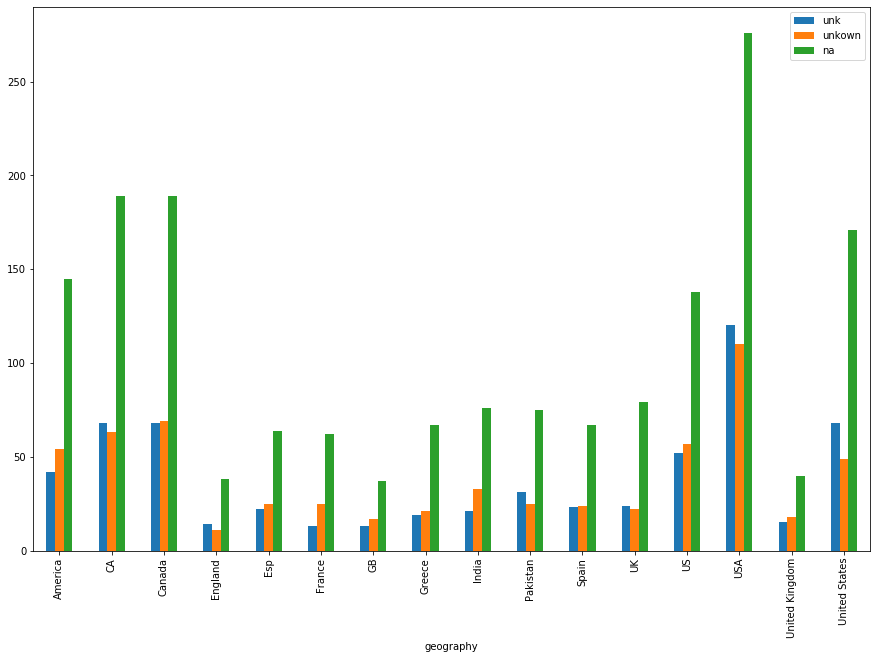

In [146]:
unknown_cat_count.plot.bar(figsize = (15,10))

In [135]:
train[train.industry=='unknown'].groupby(['geography']).count()

,id,industry,most_common_browser,session_time_prior_month_seconds,prior_month_paid
geography,,,,,
America,241,241,241,241,241
Canada,646,646,646,646,646
France,100,100,100,100,100
Greece,107,107,107,107,107
India,130,130,130,130,130
Pakistan,131,131,131,131,131
Spain,225,225,225,225,225
UK,328,328,328,328,328
US,1041,1041,1041,1041,1041


#### total session seconds sum()

In [119]:
unknown_cat.head()

,unk,unkown,na
geography,,,
America,61187,128193,279691
Canada,363622,253089,701193
France,26358,47285,136460
Greece,39709,40102,138372
India,29427,62500,143214


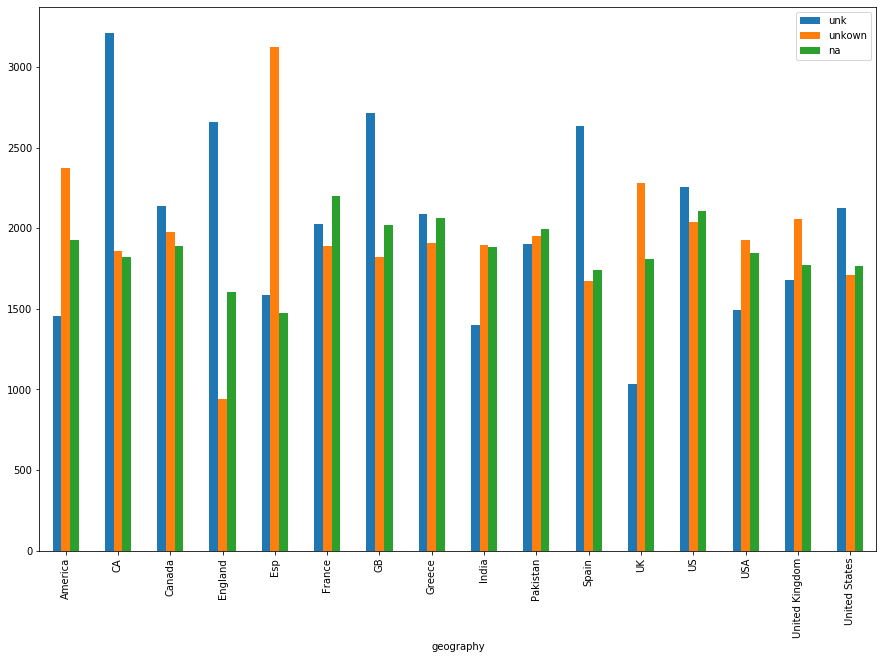

In [142]:
unknown_cat.plot.bar(figsize = (15,10))

#### given the distribution, it's safe to assume unknown is similiar to unk

In [147]:
train.loc[train.industry.isna(),'industry'] = 'unknown'

In [148]:
train.loc[train.industry == 'unk', 'industry'] = 'unknown'

In [149]:
train.industry.value_counts()

unknown             2949
Marketing Agency    1556
health care         1537
software            1533
mktg agency         1524
healthcare          1481
marketing agency    1420
Name: industry, dtype: int64

#### more on categorical data

In [51]:
train[train.industry=='unknown'].prior_month_paid.describe()

count    2949.000000
mean       60.518919
std        27.471857
min         0.080000
25%        31.145887
50%        70.547595
75%        82.445076
max       118.578664
Name: prior_month_paid, dtype: float64

In [52]:
train[train.industry!='unknown'].prior_month_paid.describe()

count    9051.000000
mean       92.954510
std        30.589263
min        17.540000
25%        69.191005
50%        97.816123
75%       117.674533
max       161.204739
Name: prior_month_paid, dtype: float64

In [129]:
train.industry.value_counts()

unknown             2949
Marketing Agency    1556
health care         1537
software            1533
mktg agency         1524
healthcare          1481
marketing agency    1420
Name: industry, dtype: int64

In [130]:
type(train.industry.value_counts())

pandas.core.series.Series

In [161]:
plt.close('all')

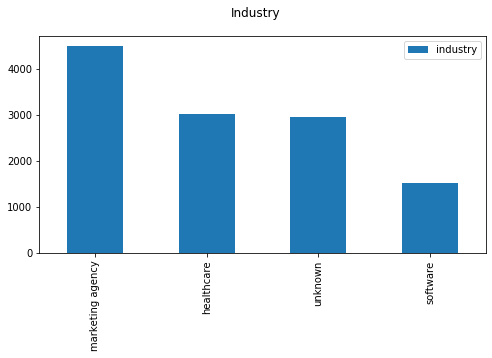

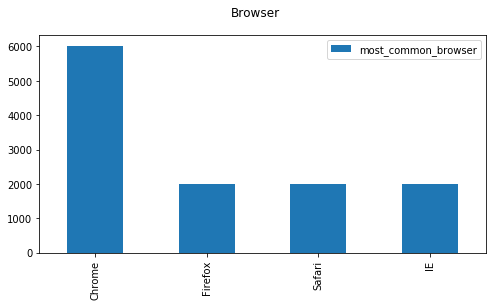

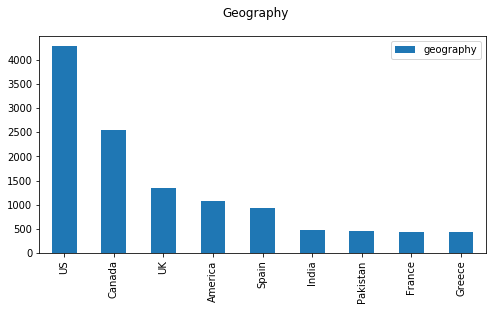

In [211]:

train.industry.value_counts().to_frame().plot.bar(figsize = (8,4))
plt.suptitle('Industry')


train.most_common_browser.value_counts().to_frame().plot.bar(figsize = (8,4))

plt.suptitle('Browser')

train.geography.value_counts().to_frame().plot.bar(figsize = (8,4))

plt.suptitle('Geography')
plt.show()

In [219]:
train.geography.value_counts()/train.shape[0]
train.most_common_browser.value_counts()/train.shape[0]


Chrome     0.501917
Firefox    0.166833
Safari     0.166000
IE         0.165250
Name: most_common_browser, dtype: float64

#### take a look at into catgorical data

In [17]:
train.describe()

,id,session_time_prior_month_seconds,prior_month_paid
count,1.200000e+04,12000.000000,12000.000000
mean,4.976514e+09,1934.527583,84.983463
std,2.877893e+09,2523.557970,32.957244
min,5.550730e+05,1.000000,0.080000
25%,2.486958e+09,607.000000,62.517315
50%,4.974383e+09,1097.000000,86.870033
75%,7.441363e+09,2284.000000,110.642275
max,9.998763e+09,35603.000000,161.204739


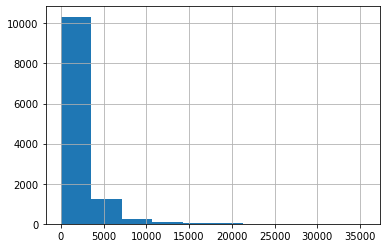

In [40]:
train.session_time_prior_month_seconds.hist()

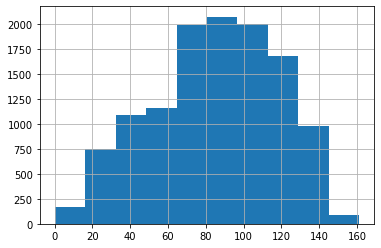

In [41]:
train.prior_month_paid.hist()

In [192]:
train['pay_per_sec'] = train.apply(lambda x:x.prior_month_paid/x.session_time_prior_month_seconds, axis = 1)

In [193]:
train.sort_values('pay_per_sec',ascending=False)

,id,industry,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid,pay_per_sec
291,1622205437,marketing agency,US,Firefox,1,111.550000,111.550000
6002,8932650208,marketing agency,America,Chrome,1,107.910000,107.910000
4908,6137928058,marketing agency,US,Safari,1,105.190000,105.190000
6246,337521627,marketing agency,Canada,IE,1,98.790000,98.790000
6928,8698428135,healthcare,US,IE,1,86.850000,86.850000
...,...,...,...,...,...,...,...
2953,5622785784,marketing agency,India,Chrome,33277,101.489938,0.003050
1913,4817104558,unknown,Canada,Chrome,35603,104.443858,0.002934
10130,3203290771,healthcare,UK,IE,27419,76.982537,0.002808
11026,7899981003,unknown,France,Chrome,20839,56.279604,0.002701


In [194]:
train.sort_values('prior_month_paid',ascending=False)

,id,industry,geography,most_common_browser,session_time_prior_month_seconds,prior_month_paid,pay_per_sec
2444,6125091066,marketing agency,America,Firefox,27698,161.204739,0.005820
8114,292930873,marketing agency,US,Firefox,20066,159.621205,0.007955
11787,3668095301,marketing agency,US,Firefox,19480,158.509675,0.008137
11108,3108954002,marketing agency,US,Chrome,29276,157.134326,0.005367
1838,2986090621,marketing agency,America,Firefox,17636,157.066364,0.008906
...,...,...,...,...,...,...,...
4901,986237723,unknown,India,Chrome,26,1.560000,0.060000
11334,8499684362,unknown,Greece,Chrome,94,1.390000,0.014787
1218,5363822847,unknown,France,Chrome,72,1.290000,0.017917
7342,5929036117,unknown,India,IE,51,0.900000,0.017647


#### average session seconds for each county or industy

In [205]:
train.groupby(['industry']).sum()

,id,session_time_prior_month_seconds,prior_month_paid,pay_per_sec
industry,,,,
healthcare,15068174703696,5978729,246785.631585,986.223994
marketing agency,22355494610493,8448872,475521.599323,1459.170610
software,7606891761903,3099480,119024.036038,263.306009
unknown,14687606140040,5687250,178470.292918,447.188665


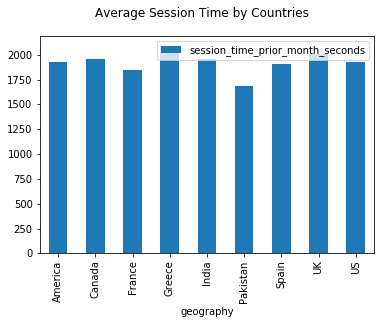

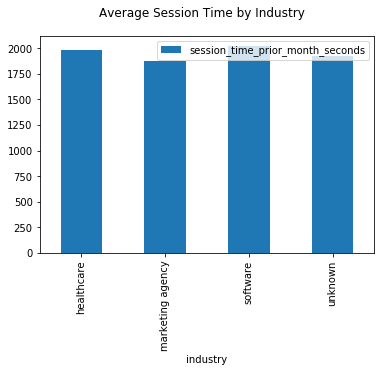

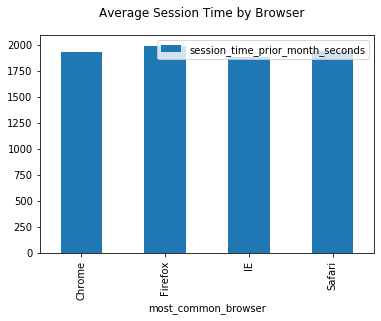

In [206]:
geo_dis = train.groupby(['geography']).mean().session_time_prior_month_seconds.to_frame()
geo_dis.plot.bar()
plt.suptitle('Average Session Time by Countries')
industy_dis = train.groupby(['industry']).mean().session_time_prior_month_seconds.to_frame()
industy_dis.plot.bar()
plt.suptitle('Average Session Time by Industry')

broswer_dis = train.groupby(['most_common_browser']).mean().session_time_prior_month_seconds.to_frame()
broswer_dis.plot.bar()
plt.suptitle('Average Session Time by Browser')

plt.show()

In [196]:
train.industry.value_counts()

marketing agency    4500
healthcare          3018
unknown             2949
software            1533
Name: industry, dtype: int64

In [208]:
broswer_dis = train.groupby(['most_common_browser']).mean()

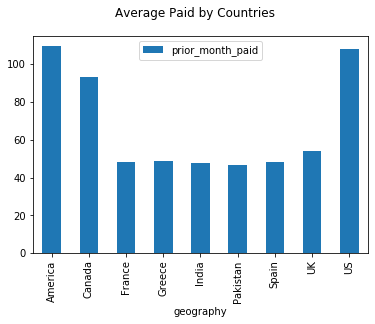

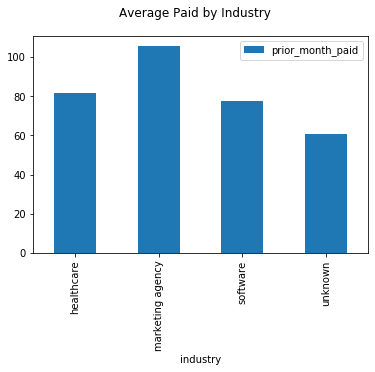

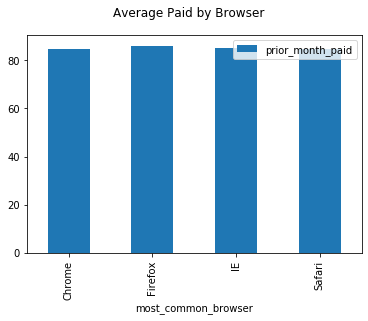

In [207]:
geo_dis = train.groupby(['geography']).mean().prior_month_paid.to_frame()
geo_dis.plot.bar()
plt.suptitle('Average Paid by Countries')
industy_dis = train.groupby(['industry']).mean().prior_month_paid.to_frame()
industy_dis.plot.bar()
plt.suptitle('Average Paid by Industry')
broswer_dis = train.groupby(['most_common_browser']).mean().prior_month_paid.to_frame()
broswer_dis.plot.bar()
plt.suptitle('Average Paid by Browser')
plt.show()

In [183]:
train.columns

Index(['id', 'industry', 'geography', 'most_common_browser',
       'session_time_prior_month_seconds', 'prior_month_paid'],
      dtype='object')

In [201]:
train.describe()

,id,session_time_prior_month_seconds,prior_month_paid,pay_per_sec
count,1.200000e+04,12000.000000,12000.000000,12000.000000
mean,4.976514e+09,1934.527583,84.983463,0.262991
std,2.877893e+09,2523.557970,32.957244,2.683686
min,5.550730e+05,1.000000,0.080000,0.000816
25%,2.486958e+09,607.000000,62.517315,0.032623
50%,4.974383e+09,1097.000000,86.870033,0.065873
75%,7.441363e+09,2284.000000,110.642275,0.137767
max,9.998763e+09,35603.000000,161.204739,111.550000


In [221]:
train.geography.value_counts()/train.shape[0]


US          0.356083
Canada      0.211583
UK          0.112083
America     0.089417
Spain       0.077500
India       0.040250
Pakistan    0.039333
France      0.037333
Greece      0.036417
Name: geography, dtype: float64

In [222]:
train.industry.value_counts()/train.shape[0]


marketing agency    0.37500
healthcare          0.25150
unknown             0.24575
software            0.12775
Name: industry, dtype: float64

In [220]:
train.most_common_browser.value_counts()/train.shape[0]


Chrome     0.501917
Firefox    0.166833
Safari     0.166000
IE         0.165250
Name: most_common_browser, dtype: float64

### Question 1  Please provide a general description of the data. This may involve descriptive statistics, graphs, or other presentation methods of your choice.


<br> The data presents customer usage of Moz.com. 
<br> Two numerical data show how long each customer use the service and how much they have paid for the prior month.
<br> Three categorical data show the industry, country and brower usage of each customers.
<br> 35% customers are from US, 37.5% customers are from Marketing Agency. 50% customers are from Chrome.
<br> The average time each customer spent is about 1900 second and they paid on average 85 for the service.
<br> Across different countries, customers for America paid more for their usage than Asian and Europe regions, while average usage time doesn't show a lot difference (which could be tested with significance test)
<br> Across different industy, marketing agency paid more for Moz.com's service, about 20% more than average
<br> Average usage and paid amount are about the same for browsers.

### Question 2 Please create a linear regression model which estimates the prior_month_paid as a function of some (or all) of the attributes contained in the file

In [378]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet,Lasso



from sklearn.pipeline import make_pipeline

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import median_absolute_error

std_scale = StandardScaler(copy=False)
min_max = MinMaxScaler(copy=False)

In [223]:
train.isna().any()

id                                  False
industry                            False
geography                           False
most_common_browser                 False
session_time_prior_month_seconds    False
prior_month_paid                    False
pay_per_sec                         False
dtype: bool

#### use one hot encoding to transform categorical date to numerical data 


In [224]:
train_for_model = pd.get_dummies(train)

In [226]:
train_for_model.columns

Index(['id', 'session_time_prior_month_seconds', 'prior_month_paid',
       'pay_per_sec', 'industry_healthcare', 'industry_marketing agency',
       'industry_software', 'industry_unknown', 'geography_America',
       'geography_Canada', 'geography_France', 'geography_Greece',
       'geography_India', 'geography_Pakistan', 'geography_Spain',
       'geography_UK', 'geography_US', 'most_common_browser_Chrome',
       'most_common_browser_Firefox', 'most_common_browser_IE',
       'most_common_browser_Safari'],
      dtype='object')

In [409]:
y = train_for_model.prior_month_paid
X = train_for_model.drop(['prior_month_paid','pay_per_sec'],axis=1)

In [410]:
X = X.set_index(['id'])

In [411]:
X.head()

,session_time_prior_month_seconds,industry_healthcare,industry_marketing agency,industry_software,industry_unknown,geography_America,geography_Canada,geography_France,geography_Greece,geography_India,geography_Pakistan,geography_Spain,geography_UK,geography_US,most_common_browser_Chrome,most_common_browser_Firefox,most_common_browser_IE,most_common_browser_Safari
id,,,,,,,,,,,,,,,,,,
8721560330,405,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5265684450,4460,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
7023768415,289,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
7733403428,4242,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
9147925075,431,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [412]:
X_scaled = std_scale.fit_transform(X)

In [413]:
pd.DataFrame(X_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04,1.200000e+04
mean,1.893855e-17,-6.033692e-16,1.525446e-16,2.624660e-16,-5.737633e-16,6.573631e-16,2.153130e-15,-7.354164e-16,-7.025908e-16,-4.744399e-16,-1.853379e-17,1.017196e-15,5.439260e-16,1.120178e-15,-5.310012e-16,7.187306e-16,-4.002447e-16,-3.127313e-16
std,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00
min,-7.662230e-01,-5.796597e-01,-7.745967e-01,-3.827013e-01,-5.708068e-01,-3.133642e-01,-5.180394e-01,-1.969293e-01,-1.944041e-01,-2.047877e-01,-2.023457e-01,-2.898462e-01,-3.552912e-01,-7.436370e-01,-1.003841e+00,-4.474819e-01,-4.449309e-01,-4.461399e-01
25%,-5.260758e-01,-5.796597e-01,-7.745967e-01,-3.827013e-01,-5.708068e-01,-3.133642e-01,-5.180394e-01,-1.969293e-01,-1.944041e-01,-2.047877e-01,-2.023457e-01,-2.898462e-01,-3.552912e-01,-7.436370e-01,-1.003841e+00,-4.474819e-01,-4.449309e-01,-4.461399e-01
50%,-3.318975e-01,-5.796597e-01,-7.745967e-01,-3.827013e-01,-5.708068e-01,-3.133642e-01,-5.180394e-01,-1.969293e-01,-1.944041e-01,-2.047877e-01,-2.023457e-01,-2.898462e-01,-3.552912e-01,-7.436370e-01,9.961740e-01,-4.474819e-01,-4.449309e-01,-4.461399e-01
75%,1.384898e-01,1.725150e+00,1.290994e+00,-3.827013e-01,-5.708068e-01,-3.133642e-01,-5.180394e-01,-1.969293e-01,-1.944041e-01,-2.047877e-01,-2.023457e-01,-2.898462e-01,-3.552912e-01,1.344742e+00,9.961740e-01,-4.474819e-01,-4.449309e-01,-4.461399e-01
max,1.334222e+01,1.725150e+00,1.290994e+00,2.613004e+00,1.751906e+00,3.191175e+00,1.930355e+00,5.077964e+00,5.143924e+00,4.883106e+00,4.942037e+00,3.450105e+00,2.814593e+00,1.344742e+00,9.961740e-01,2.234727e+00,2.247540e+00,2.241450e+00


In [414]:
pd.DataFrame(X_scaled).shape

(12000, 18)

### Below I will check Multicollinearity by calculating vif score and Normalize the input data.
<br> They are not required to for linear regression to get a correct result.
<br> Since we need to make inference on the parameters and we don't have a lot features and training data to work on. I will work on them


In [264]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(max(vif))
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [415]:
pd.DataFrame(X_scaled,columns=X.columns).head()

,session_time_prior_month_seconds,industry_healthcare,industry_marketing agency,industry_software,industry_unknown,geography_America,geography_Canada,geography_France,geography_Greece,geography_India,geography_Pakistan,geography_Spain,geography_UK,geography_US,most_common_browser_Chrome,most_common_browser_Firefox,most_common_browser_IE,most_common_browser_Safari
0,-0.606125,1.72515,-0.774597,-0.382701,-0.570807,3.191175,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,-0.743637,-1.003841,-0.447482,-0.444931,2.24145
1,1.000800,-0.57966,-0.774597,-0.382701,1.751906,-0.313364,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,2.814593,-0.743637,-1.003841,-0.447482,2.247540,-0.44614
2,-0.652094,-0.57966,1.290994,-0.382701,-0.570807,-0.313364,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,3.450105,-0.355291,-0.743637,-1.003841,2.234727,-0.444931,-0.44614
3,0.914411,-0.57966,-0.774597,-0.382701,1.751906,3.191175,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,-0.743637,-1.003841,2.234727,-0.444931,-0.44614
4,-0.595822,-0.57966,-0.774597,-0.382701,1.751906,-0.313364,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,1.344742,-1.003841,-0.447482,-0.444931,2.24145


In [416]:
calculate_vif_(pd.DataFrame(X_scaled,columns=X.columns),10)

C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


inf
dropping 'industry_healthcare' at index: 1
inf
dropping 'geography_America' at index: 4
inf
dropping 'most_common_browser_Chrome' at index: 12
Remaining variables:
Index(['session_time_prior_month_seconds', 'industry_marketing agency',
       'industry_software', 'industry_unknown', 'geography_Canada',
       'geography_France', 'geography_Greece', 'geography_India',
       'geography_Pakistan', 'geography_Spain', 'geography_UK', 'geography_US',
       'most_common_browser_Firefox', 'most_common_browser_IE',
       'most_common_browser_Safari'],
      dtype='object')


,session_time_prior_month_seconds,industry_marketing agency,industry_software,industry_unknown,geography_Canada,geography_France,geography_Greece,geography_India,geography_Pakistan,geography_Spain,geography_UK,geography_US,most_common_browser_Firefox,most_common_browser_IE,most_common_browser_Safari
0,-0.606125,-0.774597,-0.382701,-0.570807,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,-0.743637,-0.447482,-0.444931,2.24145
1,1.000800,-0.774597,-0.382701,1.751906,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,2.814593,-0.743637,-0.447482,2.247540,-0.44614
2,-0.652094,1.290994,-0.382701,-0.570807,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,3.450105,-0.355291,-0.743637,2.234727,-0.444931,-0.44614
3,0.914411,-0.774597,-0.382701,1.751906,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,-0.743637,2.234727,-0.444931,-0.44614
4,-0.595822,-0.774597,-0.382701,1.751906,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,1.344742,-0.447482,-0.444931,2.24145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-0.731746,-0.774597,-0.382701,1.751906,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,1.344742,-0.447482,-0.444931,-0.44614
11996,-0.675871,-0.774597,-0.382701,-0.570807,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,1.344742,2.234727,-0.444931,-0.44614
11997,-0.275625,-0.774597,-0.382701,-0.570807,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,1.344742,-0.447482,-0.444931,-0.44614
11998,-0.111168,-0.774597,-0.382701,-0.570807,-0.518039,-0.196929,-0.194404,-0.204788,4.942037,-0.289846,-0.355291,-0.743637,-0.447482,-0.444931,-0.44614


In [267]:
X.columns

Index(['session_time_prior_month_seconds', 'pay_per_sec',
       'industry_healthcare', 'industry_marketing agency', 'industry_software',
       'industry_unknown', 'geography_America', 'geography_Canada',
       'geography_France', 'geography_Greece', 'geography_India',
       'geography_Pakistan', 'geography_Spain', 'geography_UK', 'geography_US',
       'most_common_browser_Chrome', 'most_common_browser_Firefox',
       'most_common_browser_IE', 'most_common_browser_Safari'],
      dtype='object')

#### from above result, we can see geography_America is deteled. this could due to America is same as USA. since we don't have alot of training features, i'll drop two of three above.

In [418]:
final_x = pd.DataFrame(X_scaled,columns=X.columns).drop(['industry_healthcare','geography_America'],axis=1)
final_x.shape

(12000, 16)

In [419]:
y.shape

(12000,)

#### train test split, here i use 80%:20% 

In [420]:
y.head()

0    94.086123
1    44.434942
2    53.311472
3    98.500425
4    76.246123
Name: prior_month_paid, dtype: float64

In [421]:
X_train, X_val, y_train, y_val = train_test_split(final_x, y, test_size=0.2, random_state=1)


#### model selection

In [422]:

n_folds = 5

def mae_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    mae= np.mean(cross_val_score(model, X_train.values, y_train, scoring = 'r2',cv = kf))
    return(mae)

In [423]:
regr = ElasticNet(random_state=0,alpha=0.05)
lasso = Lasso(random_state=0,alpha=0.05)
# regr.fit(X_train, y_train)
# print(regr.coef_)
# print(regr.intercept_)

In [424]:
#y_train = df['target.sale_price']

score = mae_cv(lasso)
print("\nLasso score: {:.4f}".format(score.mean()))
score = mae_cv(regr)
print("\nElasticNet score: {:.4f} \n".format(score.mean()))


Lasso score: 0.9658

ElasticNet score: 0.9629 



#### We will choose Lasso as the model for hyper parameter tuning

In [426]:
parameters = {"alpha": [ 0.01, 0.1, 1, 10, 100]}

# use grid rearch method to tune the hyper parameters
cv = GridSearchCV(lasso, parameters, scoring = 'r2', n_jobs= -1)

grid_fit = cv.fit(X_train, y_train)


In [461]:
parameters = {"alpha": [ 0.01, 0.1, 1, 10, 100]}

# use grid rearch method to tune the hyper parameters
cv = GridSearchCV(regr, parameters, scoring = 'r2', n_jobs= -1)

els = cv.fit(X_train, y_train)


C:\Users\xiaoyal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [427]:
best_model = grid_fit.best_estimator_
best_predictions = best_model.predict(X_val)


In [428]:
grid_fit.best_params_

{'alpha': 0.01}

In [429]:
best_model.coef_

array([  7.31722232,  12.19505454,  -0.88066903,  -8.6104218 ,
        -6.20386568, -11.46968264, -11.17713612, -11.86371452,
       -11.61768283, -16.0110217 , -17.30604314,   0.        ,
         0.        ,   0.03305004,  -0.06181945,  -0.09513508])

In [430]:
len(best_model.coef_)

16

In [431]:
X_train.columns

Index(['session_time_prior_month_seconds', 'industry_marketing agency',
       'industry_software', 'industry_unknown', 'geography_Canada',
       'geography_France', 'geography_Greece', 'geography_India',
       'geography_Pakistan', 'geography_Spain', 'geography_UK', 'geography_US',
       'most_common_browser_Chrome', 'most_common_browser_Firefox',
       'most_common_browser_IE', 'most_common_browser_Safari'],
      dtype='object')

In [432]:
coef_result = pd.DataFrame(abs(best_model.coef_),index=X_train.columns)
coef_result.columns=['val']
coef_result.sort_values('val',ascending=False)

,val
geography_UK,17.306043
geography_Spain,16.011022
industry_marketing agency,12.195055
geography_India,11.863715
geography_Pakistan,11.617683
geography_France,11.469683
geography_Greece,11.177136
industry_unknown,8.610422
session_time_prior_month_seconds,7.317222
geography_Canada,6.203866


### Question 3 Please provide an inferential interpretation of the results of your regression model

1. As mentioned earlier, we've standarized features in the preprossing, so we can use the abs value of the coefficient to measure the importance of the features.
2. Geography data has a very high impact on dependant variable. Which kinda makes sense as different region would have a different experience on the service and the company could also have different products, promotions on different market.<br>
3. Marketing Agency is also very high, as most of the customer who use Moz products are from that industry.
4. Browsers have very low importance on the dependant variable <br>
5. Lass helps to remove two variables, one of those is actually detected for calculating VIF score. We could've removed it ealier to safe training time. 
6. It would be nice to have p values and confidence intervals on certain parameters. But unformately Sklean doesn't provide those. It's something to consider when choosing training libraries.

### Question 4 Please run your model against the training data set, and describe it’s performance.
I assume this was asking for test against testing data

In [440]:
test_process = test.drop(['id','prior_month_paid'],axis=1)
y_test = test.prior_month_paid

In [441]:
test_process.loc[test_process.industry.isna(),'industry'] = 'unknown'

In [442]:
test_process.loc[test_process.industry=='unk','industry'] = 'unknown'

In [443]:
test_process.industry = test_process.industry.apply(lambda x:industry_dic[x] if x in industry_dic else x)

In [444]:
country_dic['America'] = 'US'
test_process.geography = test_process.geography.apply(lambda x:country_dic[x] if x in country_dic else x)

In [445]:
test_process.industry.value_counts()

marketing agency    18095
unknown             12063
healthcare          11963
software             5879
Name: industry, dtype: int64

In [446]:
test_process.geography.value_counts()

US          21457
Canada      10709
UK           5260
Spain        3483
Pakistan     1797
Greece       1782
India        1773
France       1739
Name: geography, dtype: int64

In [447]:
test_process.describe()

,session_time_prior_month_seconds
count,48000.000000
mean,1952.151854
std,2579.835645
min,1.000000
25%,612.000000
50%,1210.000000
75%,2289.000000
max,50233.000000


In [448]:
test_process.isna().any()

industry                            False
geography                           False
most_common_browser                 False
session_time_prior_month_seconds    False
dtype: bool

In [449]:
test_process_dum = pd.get_dummies(test_process)

In [450]:
test_process_dum.drop('industry_healthcare',axis=1,inplace = True)

In [451]:
len(test_process_dum.columns)

16

In [452]:
test_scaled = std_scale.fit_transform(test_process_dum)

In [453]:
test_result = best_model.predict(test_scaled)

In [463]:
t2 = els.best_estimator_.predict(test_scaled)

In [462]:
test_scaled.shape

(48000, 16)

In [455]:
pd.DataFrame(test_scaled,columns=test_process_dum.columns).describe()

,session_time_prior_month_seconds,industry_marketing agency,industry_software,industry_unknown,geography_Canada,geography_France,geography_Greece,geography_India,geography_Pakistan,geography_Spain,geography_UK,geography_US,most_common_browser_Chrome,most_common_browser_Firefox,most_common_browser_IE,most_common_browser_Safari
count,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04,4.800000e+04
mean,1.032507e-17,5.417380e-16,1.878245e-15,2.366958e-15,7.653091e-16,-1.756390e-15,-5.754517e-16,5.401038e-16,8.868566e-16,1.184728e-15,-2.560658e-15,1.173830e-16,7.854134e-16,3.931355e-15,5.892532e-16,-6.298226e-16
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-7.563165e-01,-7.778707e-01,-3.735962e-01,-5.793710e-01,-5.358860e-01,-1.938841e-01,-1.963579e-01,-1.958423e-01,-1.972145e-01,-2.797137e-01,-3.508129e-01,-8.991031e-01,-1.008116e+00,-4.445612e-01,-4.450316e-01,-4.455355e-01
25%,-5.194772e-01,-7.778707e-01,-3.735962e-01,-5.793710e-01,-5.358860e-01,-1.938841e-01,-1.963579e-01,-1.958423e-01,-1.972145e-01,-2.797137e-01,-3.508129e-01,-8.991031e-01,-1.008116e+00,-4.445612e-01,-4.450316e-01,-4.455355e-01
50%,-2.876771e-01,-7.778707e-01,-3.735962e-01,-5.793710e-01,-5.358860e-01,-1.938841e-01,-1.963579e-01,-1.958423e-01,-1.972145e-01,-2.797137e-01,-3.508129e-01,-8.991031e-01,9.919491e-01,-4.445612e-01,-4.450316e-01,-4.455355e-01
75%,1.305710e-01,1.285561e+00,-3.735962e-01,1.726010e+00,-5.358860e-01,-1.938841e-01,-1.963579e-01,-1.958423e-01,-1.972145e-01,-2.797137e-01,-3.508129e-01,1.112219e+00,9.919491e-01,-4.445612e-01,-4.450316e-01,-4.455355e-01
max,1.871489e+01,1.285561e+00,2.676687e+00,1.726010e+00,1.866068e+00,5.157719e+00,5.092743e+00,5.106149e+00,5.070620e+00,3.575084e+00,2.850522e+00,1.112219e+00,9.919491e-01,2.249409e+00,2.247031e+00,2.244490e+00


In [456]:
X_train.describe()

,session_time_prior_month_seconds,industry_marketing agency,industry_software,industry_unknown,geography_Canada,geography_France,geography_Greece,geography_India,geography_Pakistan,geography_Spain,geography_UK,geography_US,most_common_browser_Chrome,most_common_browser_Firefox,most_common_browser_IE,most_common_browser_Safari
count,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000
mean,0.003090,-0.003658,0.008925,-0.001742,0.008110,-0.005714,0.002447,0.000848,-0.004073,0.003506,-0.010566,0.000783,0.003250,0.001509,-0.006002,0.000112
std,1.000353,0.999100,1.009917,0.999021,1.005731,0.985990,1.006086,1.002033,0.990345,1.005571,0.986916,1.000287,1.000034,1.001398,0.994609,1.000153
min,-0.766223,-0.774597,-0.382701,-0.570807,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,-0.743637,-1.003841,-0.447482,-0.444931,-0.446140
25%,-0.525680,-0.774597,-0.382701,-0.570807,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,-0.743637,-1.003841,-0.447482,-0.444931,-0.446140
50%,-0.331897,-0.774597,-0.382701,-0.570807,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,-0.743637,0.996174,-0.447482,-0.444931,-0.446140
75%,0.139679,1.290994,-0.382701,-0.570807,-0.518039,-0.196929,-0.194404,-0.204788,-0.202346,-0.289846,-0.355291,1.344742,0.996174,-0.447482,-0.444931,-0.446140
max,13.342224,1.290994,2.613004,1.751906,1.930355,5.077964,5.143924,4.883106,4.942037,3.450105,2.814593,1.344742,0.996174,2.234727,2.247540,2.241450


In [457]:
test_result

array([ 26.10510953, 105.38372955,  88.09868969, ...,  95.89296001,
       124.65235856, 104.05706409])

In [458]:
y_test

0         25.607595
1        115.579494
2         89.462246
3         33.836123
4        129.394415
            ...    
47995    103.682246
47996    124.759101
47997    105.044942
47998    117.116123
47999    108.509179
Name: prior_month_paid, Length: 48000, dtype: float64

#### we have a r2 score really close to 1, meaning we have a good fit.

In [460]:
r2_score(test_result,y_test)

0.9635442295995793

### Question 5 What would your recommended next steps for the business be?

1. unknown industry paid less than other industries, probably worth investigation to indentify the industry to bring in more revenue.<br> 
2. Gather more data for more accurate models. <br> 
3. Focusing marketing effort on geography features. As data shows that they have a higher importance than other features.
4. Look into why browsers are not affecting the overal customer paid amount. 